### RDD to Dataframe

In [10]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col

In [2]:
sc = SparkContext()
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()

22/04/30 18:00:09 WARN Utils: Your hostname, PANZER resolves to a loopback address: 127.0.1.1; using 172.28.24.15 instead (on interface eth0)
22/04/30 18:00:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 18:00:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
rdd = sc.parallelize([[1,'Alice',50,False],[2,'Bob',80,True]])

In [4]:
df = rdd.toDF()

In [5]:
df.show()

+---+-----+---+-----+
| _1|   _2| _3|   _4|
+---+-----+---+-----+
|  1|Alice| 50|false|
|  2|  Bob| 80| true|
+---+-----+---+-----+



In [6]:
df.printSchema()

root
 |-- _1: long (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)
 |-- _4: boolean (nullable = true)



In [7]:
df = df.withColumnRenamed("_1","id").withColumnRenamed("_2","name").withColumnRenamed("_3","score").withColumnRenamed("_4","pass")

In [8]:
df.show()

+---+-----+-----+-----+
| id| name|score| pass|
+---+-----+-----+-----+
|  1|Alice|   50|false|
|  2|  Bob|   80| true|
+---+-----+-----+-----+



In [11]:
df.select('name','score','pass').filter(col('id')==1).show()

+-----+-----+-----+
| name|score| pass|
+-----+-----+-----+
|Alice|   50|false|
+-----+-----+-----+



In [12]:
df.withColumn('sum',col('id')+col('score')).show()

+---+-----+-----+-----+---+
| id| name|score| pass|sum|
+---+-----+-----+-----+---+
|  1|Alice|   50|false| 51|
|  2|  Bob|   80| true| 82|
+---+-----+-----+-----+---+



In [13]:
df.withColumn('false_pass',col('pass')==False).show()

+---+-----+-----+-----+----------+
| id| name|score| pass|false_pass|
+---+-----+-----+-----+----------+
|  1|Alice|   50|false|      true|
|  2|  Bob|   80| true|     false|
+---+-----+-----+-----+----------+



In [14]:
import pandas as pd

In [15]:
df_pandas = df.toPandas() #single machine, not distributed
df_pandas

,id,name,score,pass
0,1,Alice,50,False
1,2,Bob,80,True


In [16]:
df_spark = spark.createDataFrame(df_pandas).show()

+---+-----+-----+-----+
| id| name|score| pass|
+---+-----+-----+-----+
|  1|Alice|   50|false|
|  2|  Bob|   80| true|
+---+-----+-----+-----+



### London crime data

In [17]:
from pyspark.sql import SparkSession
import wget
from pyspark.sql.functions import col,round, sum, min,max
import matplotlib.pyplot as plt

In [18]:
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()

In [ ]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/london_crime_by_lsoa.csv','.') #889.6 Mb

In [19]:
data = spark.read.csv('london_crime_by_lsoa.csv',header=True,sep=',',inferSchema=True)

In [20]:
data.show(5)

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [21]:
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [22]:
data.cache()
data.count()

13490604

In [23]:
data.dropna()

DataFrame[lsoa_code: string, borough: string, major_category: string, minor_category: string, value: int, year: int, month: int]

In [24]:
data = data.drop('lsoa_code')

In [25]:
data.select(col('borough')).distinct().show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [26]:
data.filter(col('borough')=='Hackney').show()

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
|Hackney|            Burglary|Burglary in a Dwe...|    2|2008|    5|
|Hackney|             Robbery|   Business Property|    0|2016|    7|
|Hackney|  Theft and Handling|Theft/Taking of P...|    0|2009|   12|
|Hackney|               Drugs|    Drug Trafficking|    0|2014|    4|
|Hackney|  Theft and Handling|Handling Stolen G...|    0|2014|    6|
|Hackney|            Burglary|Burglary in Other...|    0|2008|   12|
|Hackney|Violence Against ...| Ass

In [27]:
data.filter(col('year').isin('2015','2016')).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|              Sutton|  Theft and Handling|Theft/Taking of P...|    1|2016|    8|
|             Lambeth|Violence Against ...|      Other violence|    0|2015|    4|
|          Hillingdon|  Theft and Handling|Theft/Taking Of M...|    0|2016|    2|
|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|            Haringey|Violence Against ...|        Wounding/GBH|    0|2015|   12|
|            Lew

In [28]:
data.sample(fraction=0.1).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|          Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
|              Sutton|  Theft and Handling|Theft/Taking of P...|    1|2016|    8|
|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|              Sutton|               Drugs| Possession Of Drugs|    0|2009|   10|
|            Hounslow|     Criminal Damage|Criminal Damage T...|    0|2015|    2|
|           Southwark|               Drugs| Possession Of Drugs|    0|2015|    3|
|           Southwark|  Theft and Handling|    Theft From Shops|    4|2016|    8|
|             Lambeth|Violence Against ...| Assault with Injury|    2|2008|    5|
|           Isli

In [29]:
data.filter(col('year') >= 2014).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|              Sutton|  Theft and Handling|Theft/Taking of P...|    1|2016|    8|
|             Lambeth|Violence Against ...|      Other violence|    0|2015|    4|
|Richmond upon Thames|             Robbery|   Personal Property|    0|2014|    1|
|          Hillingdon|  Theft and Handling|Theft/Taking Of M...|    0|2016|    2|
|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|            Har

In [30]:
data.groupBy('borough').count().show()

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|602100|
|          Wandsworth|498636|
|              Bexley|385668|
|             Lambeth|519048|
|Barking and Dagenham|311040|
|              Camden|378432|
|           Greenwich|421200|
|              Newham|471420|
|       Tower Hamlets|412128|
|            Hounslow|395928|
|              Barnet|572832|
|              Harrow|365688|
|Kensington and Ch...|296784|
|           Islington|359208|
|               Brent|490644|
|            Haringey|413856|
|             Bromley|523908|
|              Merton|339876|
|         Westminster|366660|
|             Hackney|417744|
+--------------------+------+
only showing top 20 rows



In [31]:
data.groupBy('borough').agg({'value':'sum'}).show()

+--------------------+----------+
|             borough|sum(value)|
+--------------------+----------+
|             Croydon|    260294|
|          Wandsworth|    204741|
|              Bexley|    114136|
|             Lambeth|    292178|
|Barking and Dagenham|    149447|
|              Camden|    275147|
|           Greenwich|    181568|
|              Newham|    262024|
|       Tower Hamlets|    228613|
|            Hounslow|    186772|
|              Barnet|    212191|
|              Harrow|    116848|
|Kensington and Ch...|    171981|
|           Islington|    230286|
|               Brent|    227551|
|            Haringey|    213272|
|             Bromley|    184349|
|              Merton|    115654|
|         Westminster|    455028|
|             Hackney|    217119|
+--------------------+----------+
only showing top 20 rows



In [32]:
borough_conviction_sum = data.groupBy('borough').agg({'value':'sum'}).withColumnRenamed('sum(value)','convictions')

In [33]:
data.groupBy().sum('value').show()

+----------+
|sum(value)|
+----------+
|   6447758|
+----------+



In [34]:
data.agg({'value':'sum'}).show()

+----------+
|sum(value)|
+----------+
|   6447758|
+----------+



In [35]:
total_convictions = data.agg({'value':'sum'}).collect()[0][0]
total_convictions

6447758

In [36]:
percentage = borough_conviction_sum.withColumn('perc_contrib',round(borough_conviction_sum.convictions / total_convictions * 100,2))
percentage.orderBy(col('perc_contrib').desc()).show()

+--------------------+-----------+------------+
|             borough|convictions|perc_contrib|
+--------------------+-----------+------------+
|         Westminster|     455028|        7.06|
|             Lambeth|     292178|        4.53|
|           Southwark|     278809|        4.32|
|              Camden|     275147|        4.27|
|              Newham|     262024|        4.06|
|             Croydon|     260294|        4.04|
|              Ealing|     251562|         3.9|
|           Islington|     230286|        3.57|
|       Tower Hamlets|     228613|        3.55|
|               Brent|     227551|        3.53|
|             Hackney|     217119|        3.37|
|            Lewisham|     215137|        3.34|
|            Haringey|     213272|        3.31|
|              Barnet|     212191|        3.29|
|          Hillingdon|     209680|        3.25|
|          Wandsworth|     204741|        3.18|
|      Waltham Forest|     203879|        3.16|
|             Enfield|     193880|      

In [37]:
month_convictions = (data.filter(col('year') == 2014)
.groupBy(col('month'))
.agg(sum(col('value')).alias('convictions'))
)

In [38]:
total_month = (month_convictions.agg(sum(col('convictions'))).collect()[0][0]
)
total_month

680183

In [39]:
month_convictions = (month_convictions.withColumn('percent',round(col('convictions')/total_month * 100,2))
)

month_convictions.orderBy(col('percent').desc()).show()

+-----+-----------+-------+
|month|convictions|percent|
+-----+-----------+-------+
|   10|      60537|    8.9|
|   11|      59704|   8.78|
|    7|      58564|   8.61|
|    3|      57669|   8.48|
|   12|      57565|   8.46|
|    6|      57039|   8.39|
|    9|      56933|   8.37|
|    5|      56327|   8.28|
|    8|      55641|   8.18|
|    1|      55515|   8.16|
|    4|      53467|   7.86|
|    2|      51222|   7.53|
+-----+-----------+-------+



In [40]:
crimes = (
    data.groupBy('major_category')
    .agg(sum(col('value')).alias('convictions'))
)
crimes.orderBy(col('convictions').desc()).show()

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|  Theft and Handling|    2661861|
|Violence Against ...|    1558081|
|            Burglary|     754293|
|     Criminal Damage|     630938|
|               Drugs|     470765|
|             Robbery|     258873|
|Other Notifiable ...|     106349|
|    Fraud or Forgery|       5325|
|     Sexual Offences|       1273|
+--------------------+-----------+



In [41]:
data.agg(min(col('year'))).show()


+---------+
|min(year)|
+---------+
|     2008|
+---------+



In [42]:
data.agg(max(col('year'))).show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [43]:
data.describe().show()

+-------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+
|summary|             borough|      major_category|     minor_category|             value|              year|            month|
+-------+--------------------+--------------------+-------------------+------------------+------------------+-----------------+
|  count|            13490604|            13490604|           13490604|          13490604|          13490604|         13490604|
|   mean|                null|                null|               null|0.4779443529733732|            2012.0|              6.5|
| stddev|                null|                null|               null|1.7715128643050109|2.5819889931674265|3.452052657477519|
|    min|Barking and Dagenham|            Burglary|Assault with Injury|                 0|              2008|                1|
|    max|         Westminster|Violence Against ...|       Wounding/GBH|               309|              

In [44]:
data.crosstab('borough','major_category').show()

+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|borough_major_category|Burglary|Criminal Damage|Drugs|Fraud or Forgery|Other Notifiable Offences|Robbery|Sexual Offences|Theft and Handling|Violence Against the Person|
+----------------------+--------+---------------+-----+----------------+-------------------------+-------+---------------+------------------+---------------------------+
|              Havering|   32400|          64152|32616|            5508|                    21060|  27648|           1944|            118800|                      95472|
|                Merton|   26784|          52920|29160|            5724|                    19440|  23652|           2592|            101196|                      78408|
|              Haringey|   31320|          62424|35424|           10368|                    23760|  29484|           3780|            120420|         

In [45]:
year = 2014
yearly_details = (data.filter(col('year')==year)
                        .groupBy('borough')
                        .agg(sum('value').alias('convictions')).orderBy(col('convictions').desc())
)

yearly_details.show()

+--------------+-----------+
|       borough|convictions|
+--------------+-----------+
|   Westminster|      47564|
|       Lambeth|      31765|
|     Southwark|      28912|
|        Newham|      28005|
|       Croydon|      27357|
|        Camden|      27198|
| Tower Hamlets|      25504|
|        Ealing|      24978|
|       Hackney|      24893|
|     Islington|      24679|
|         Brent|      24426|
|    Hillingdon|      23128|
|      Haringey|      22773|
|        Barnet|      22572|
|       Enfield|      21700|
|    Wandsworth|      21364|
|      Lewisham|      21101|
|Waltham Forest|      20271|
|      Hounslow|      20005|
|     Greenwich|      19894|
+--------------+-----------+
only showing top 20 rows



In [46]:
borough_list = [row['borough'] for row in yearly_details.collect()]
convictions_list = [row['convictions'] for row in yearly_details.collect()]


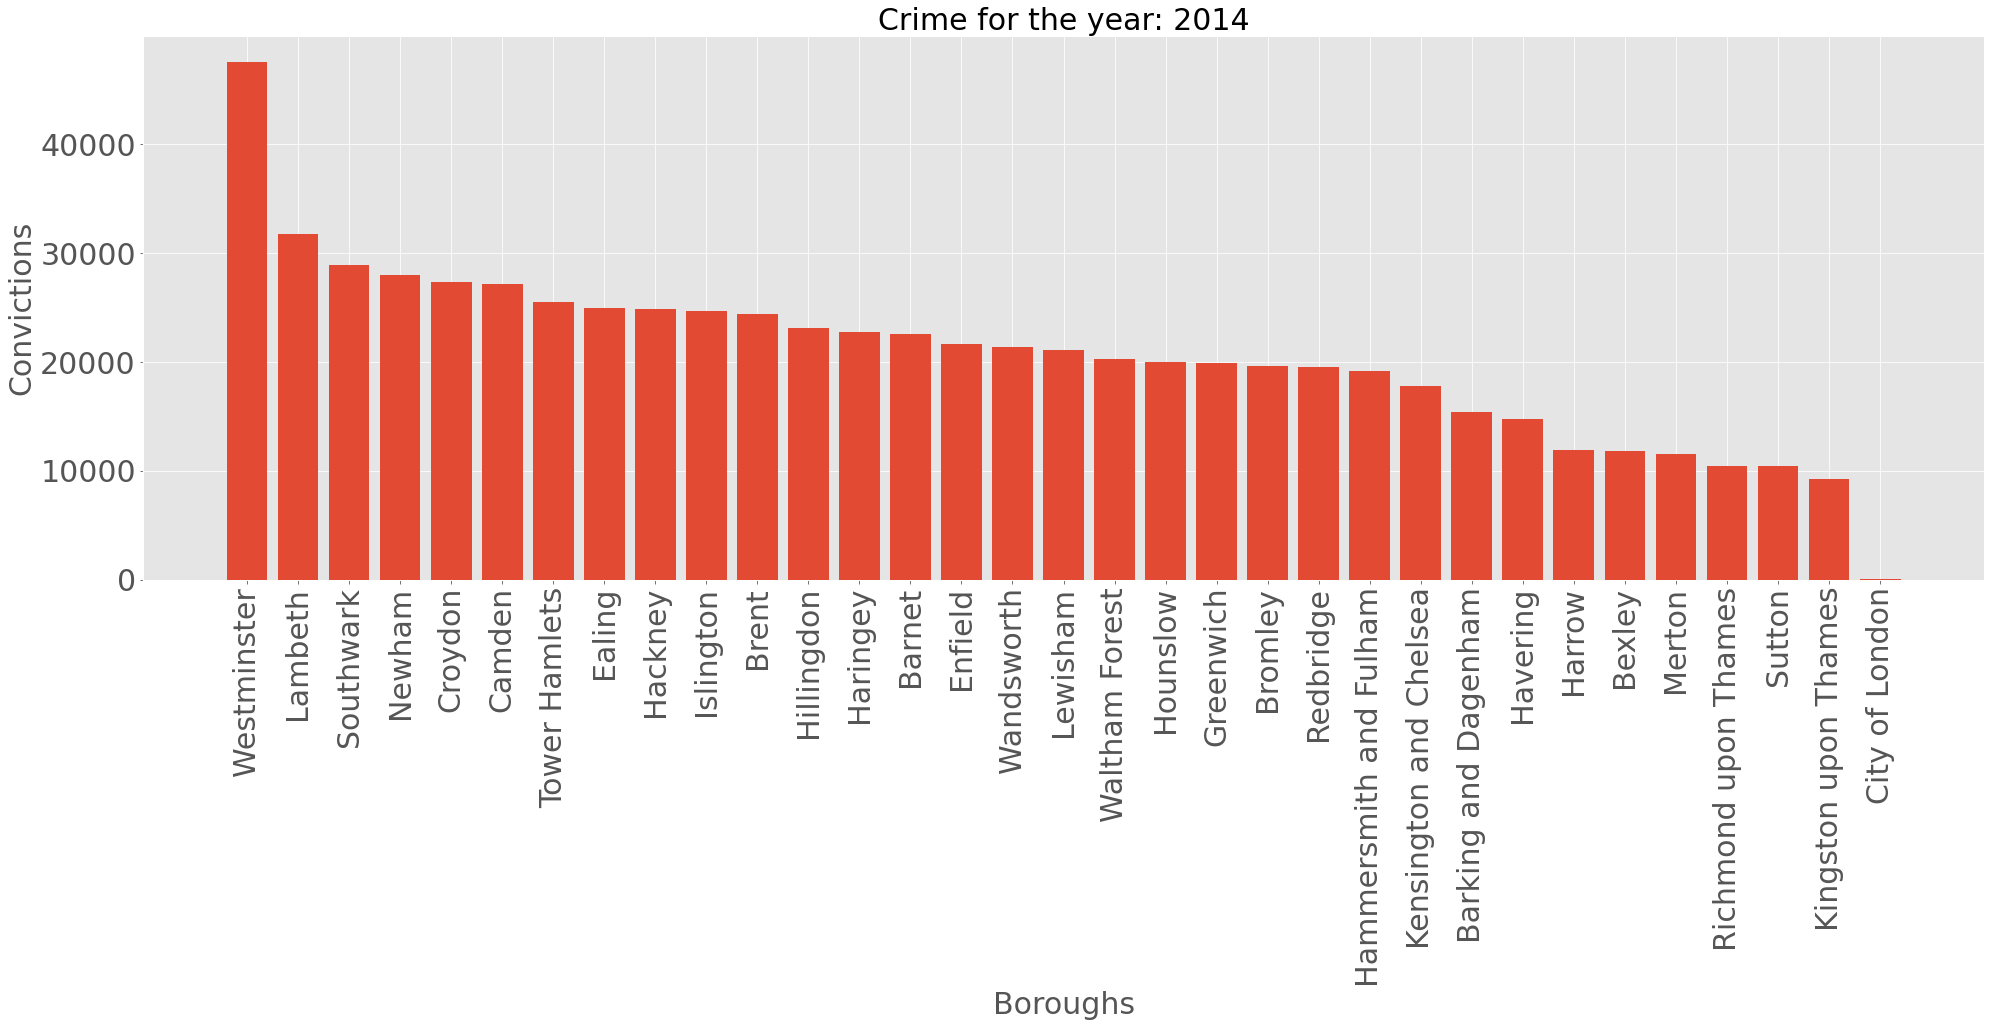

In [47]:
    plt.style.use('ggplot')
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + str(year), fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

### Soccer Players

In [48]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, col, avg, broadcast
import wget

In [49]:
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()

In [ ]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/player.csv','.') #688.3 Kb

In [50]:
players = spark.read.csv('player.csv',inferSchema=True,header=True)

In [51]:
players.show(5)

+---+-------------+------------------+------------------+-------------------+------+------+
| id|player_api_id|       player_name|player_fifa_api_id|           birthday|height|weight|
+---+-------------+------------------+------------------+-------------------+------+------+
|  1|       505942|Aaron Appindangoye|            218353|1992-02-29 00:00:00|182.88|   187|
|  2|       155782|   Aaron Cresswell|            189615|1989-12-15 00:00:00|170.18|   146|
|  3|       162549|       Aaron Doran|            186170|1991-05-13 00:00:00|170.18|   163|
|  4|        30572|     Aaron Galindo|            140161|1982-05-08 00:00:00|182.88|   198|
|  5|        23780|      Aaron Hughes|             17725|1979-11-08 00:00:00|182.88|   154|
+---+-------------+------------------+------------------+-------------------+------+------+
only showing top 5 rows



In [52]:
players.printSchema()

root
 |-- id: integer (nullable = true)
 |-- player_api_id: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_fifa_api_id: integer (nullable = true)
 |-- birthday: string (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: integer (nullable = true)



In [53]:
players.describe().show()

+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+
|summary|               id|     player_api_id|         player_name|player_fifa_api_id|           birthday|            height|            weight|
+-------+-----------------+------------------+--------------------+------------------+-------------------+------------------+------------------+
|  count|            11060|             11060|               11060|             11060|              11060|             11060|             11060|
|   mean|5537.511392405063|156582.42721518988|                null|165664.91048824592|               null|181.86744484628662|168.38028933092224|
| stddev|3197.692646865559|160713.70062373235|                null| 58649.92836028494|               null| 6.369200906779242|14.990217454102865|
|    min|                1|              2625|  Aaron Appindangoye|                 2|1967-01-23 00:00:00|            157.48|     

In [55]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/player_attributes.csv','.') #28.2 Mb

'./player_attributes (1).csv'

In [56]:
player_att = spark.read.csv('player_attributes.csv',inferSchema=True, header=True)

In [57]:
player_att.to_pandas_on_spark().head(5)

22/04/30 18:05:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/30 18:05:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/30 18:05:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67,71,right,medium,medium,49,44,71,61,44,51,45,39,64,49,60,64,59,47,65,55,58,54,76,35,71,70,45,54,48,65,69,69,6,11,10,8,8
1,2,218353,505942,2015-11-19 00:00:00,67,71,right,medium,medium,49,44,71,61,44,51,45,39,64,49,60,64,59,47,65,55,58,54,76,35,71,70,45,54,48,65,69,69,6,11,10,8,8
2,3,218353,505942,2015-09-21 00:00:00,62,66,right,medium,medium,49,44,71,61,44,51,45,39,64,49,60,64,59,47,65,55,58,54,76,35,63,41,45,54,48,65,66,69,6,11,10,8,8
3,4,218353,505942,2015-03-20 00:00:00,61,65,right,medium,medium,48,43,70,60,43,50,44,38,63,48,60,64,59,46,65,54,58,54,76,34,62,40,44,53,47,62,63,66,5,10,9,7,7
4,5,218353,505942,2007-02-22 00:00:00,61,65,right,medium,medium,48,43,70,60,43,50,44,38,63,48,60,64,59,46,65,54,58,54,76,34,62,40,44,53,47,62,63,66,5,10,9,7,7


In [58]:
players.select('player_api_id').distinct().count()

11060

In [59]:
player_att.select('player_api_id').distinct().count()

11060

In [60]:
players = players.drop('id','player_fifa_api_id')

In [61]:
player_att = (player_att.drop(
'id',
'player_fifa_api_id',
'preferred_foot',
'attacking_work_rate',
'defensive_work_rate',
'crossing',
'jumping',
'sprint_speed',
'balance',
'aggression',
'short_passing',
'potential'
)
)

In [62]:
players = players.dropna()
player_att = player_att.dropna()

In [63]:
player_att = player_att.withColumn('year',year(col('date')))

In [64]:
player_att = player_att.drop('date')

In [65]:
p_2016 = player_att.filter(col('year')==2016)

In [66]:
p_2016.cache()
p_2016.count()

14098

In [67]:
striker_2016 = (p_2016
.groupBy('player_api_id')
.agg(
    avg(col('finishing')).alias('finishing'),
    avg(col('shot_power')).alias('shot_power'),
    avg(col('acceleration')).alias('acceleration')
    )
)

In [68]:
striker_2016.show(5)

+-------------+-----------------+----------+-----------------+
|player_api_id|        finishing|shot_power|     acceleration|
+-------------+-----------------+----------+-----------------+
|       114503|             78.0|      75.0|             77.0|
|       171094|             39.0|      36.0|             65.0|
|        27484|             61.0|      71.0|71.66666666666667|
|       166648|86.83333333333333|      81.0|             84.0|
|       352887|             70.0|      75.0|             65.0|
+-------------+-----------------+----------+-----------------+
only showing top 5 rows



In [69]:
weight_finishing = 1
weight_shot_power = 2
weight_acceleration = 1

total_weight = weight_finishing + weight_shot_power + weight_acceleration

In [70]:
striker = striker_2016.withColumn('striker_grade', (col('finishing') * weight_finishing + col('shot_power') * weight_shot_power +  col('acceleration') * weight_acceleration )/total_weight )

In [71]:
striker = striker.drop('finishing','shot_power','acceleration')

In [72]:
good_strikers = striker.filter(col('striker_grade')>70).orderBy(col('striker_grade').desc())

In [73]:
good_strikers.show(10)

+-------------+-----------------+
|player_api_id|    striker_grade|
+-------------+-----------------+
|        20276|            89.25|
|        37412|             89.0|
|        38817|            88.75|
|        32118|            88.25|
|        31921|             87.0|
|        30834|            86.75|
|       303824|85.10714285714286|
|       129944|             85.0|
|       158263|            84.75|
|       150565|            84.75|
+-------------+-----------------+
only showing top 10 rows



In [74]:
striker_details = (players.alias('p')
.join(broadcast(good_strikers).alias('gs'),
on=[col('p.player_api_id')==col('gs.player_api_id')],
how='inner')
.select('p.*','gs.striker_grade')
)

In [75]:
striker_details.show(5)

+-------------+-----------------+-------------------+------+------+-------------+
|player_api_id|      player_name|           birthday|height|weight|striker_grade|
+-------------+-----------------+-------------------+------+------+-------------+
|        27316|       Aaron Hunt|1986-09-04 00:00:00|182.88|   161|        74.75|
|        40719|     Aaron Niguez|1989-04-26 00:00:00|170.18|   143|        74.25|
|        75489|     Aaron Ramsey|1990-12-26 00:00:00| 177.8|   154|       76.875|
|       120919|Aatif Chahechouhe|1986-07-02 00:00:00|175.26|   150|         78.0|
|        67334|Abdoul Karim Yoda|1988-10-25 00:00:00|182.88|   161|         74.0|
+-------------+-----------------+-------------------+------+------+-------------+
only showing top 5 rows



In [76]:
heading_acc = (player_att.alias('pa')
.join(broadcast(players).alias('p'),on=[col('p.player_api_id')==col('pa.player_api_id')],how='inner')
.select('p.player_api_id','pa.heading_accuracy','p.height')
)

In [77]:
short_count = spark.sparkContext.accumulator(0)
medium_low_count = spark.sparkContext.accumulator(0)
medium_high_count = spark.sparkContext.accumulator(0)
tall_count = spark.sparkContext.accumulator(0)

In [78]:
def count_players_by_height(row):
    height = float(row.height)

    if (height <= 175):
        short_count.add(1)
    elif (height <= 183 and height > 175):
        medium_low_count.add(1)
    elif (height <= 195 and height> 183):
        medium_high_count.add(1)
    else:
        tall_count.add(1)

In [79]:
heading_acc.foreach(lambda x: count_players_by_height(x))

In [80]:
[short_count.value,medium_low_count.value,medium_high_count.value,tall_count.value]

[18977, 97399, 61518, 3371]

In [81]:
short_ha_count = spark.sparkContext.accumulator(0)
medium_ha_low_count = spark.sparkContext.accumulator(0)
medium_ha_high_count = spark.sparkContext.accumulator(0)
tall_ha_count = spark.sparkContext.accumulator(0)

In [82]:
def count_players_by_height_and_ha(row, threshold_score):
    height = float(row.height)
    ha = float(row.heading_accuracy)

    if ha <= threshold_score:
        return

    if (height <= 175):
        short_ha_count.add(1)
    elif (height <= 183 and height > 175):
        medium_ha_low_count.add(1)
    elif (height <= 195 and height> 183):
        medium_ha_high_count.add(1)
    else:
        tall_ha_count.add(1)

In [83]:
heading_acc.foreach(lambda x: count_players_by_height_and_ha(x,60))

In [84]:
[short_ha_count.value,medium_ha_low_count.value,medium_ha_high_count.value,tall_ha_count.value]

[3653, 41448, 40270, 1573]

In [85]:
[short_ha_count.value/short_count.value *100,
medium_ha_low_count.value/medium_low_count.value *100,
medium_ha_high_count.value/medium_high_count.value *100,
tall_ha_count.value/tall_count.value *100
]

[19.249617958581442, 42.55485169252251, 65.46051562144413, 46.66271136161376]

In [86]:
p_2016.rdd.getNumPartitions()

8

In [87]:
p_2016.repartition(1).write.csv(path='csv',mode='overwrite',sep=';',header=True)

In [88]:
p_2016.write.orc(path='orc',mode='overwrite')

In [89]:
p_2016.repartition(1).write.json(path='json',mode='overwrite')

### Spark SQL

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import Row
from datetime import datetime

In [2]:
sc = SparkContext()
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()


22/04/30 18:08:21 WARN Utils: Your hostname, PANZER resolves to a loopback address: 127.0.1.1; using 172.28.24.15 instead (on interface eth0)
22/04/30 18:08:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 18:08:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
record = sc.parallelize([
Row(id=1, name='Jill', active = True, clubs = ['chess','hockey'],subjects = {"math":80, "english": 56}, enrolled = datetime(2014,8,1,14,1,5)),
Row(id=2, name='George', active = False, clubs = ['chess','soccer'],subjects = {"math":60, "english": 96}, enrolled = datetime(2015,3,21,8,2,5))
])

In [4]:
df = record.toDF()
df.show()

+---+------+------+---------------+--------------------+-------------------+
| id|  name|active|          clubs|            subjects|           enrolled|
+---+------+------+---------------+--------------------+-------------------+
|  1|  Jill|  true|[chess, hockey]|{english -> 56, m...|2014-08-01 14:01:05|
|  2|George| false|[chess, soccer]|{english -> 96, m...|2015-03-21 08:02:05|
+---+------+------+---------------+--------------------+-------------------+



In [5]:
df.createOrReplaceTempView('records')

In [7]:
spark.sql('SELECT * FROM records').show()

+---+------+------+---------------+--------------------+-------------------+
| id|  name|active|          clubs|            subjects|           enrolled|
+---+------+------+---------------+--------------------+-------------------+
|  1|  Jill|  true|[chess, hockey]|{english -> 56, m...|2014-08-01 14:01:05|
|  2|George| false|[chess, soccer]|{english -> 96, m...|2015-03-21 08:02:05|
+---+------+------+---------------+--------------------+-------------------+



In [8]:
spark.sql('SELECT id, clubs[1],subjects["english"] FROM records').show()

+---+--------+-----------------+
| id|clubs[1]|subjects[english]|
+---+--------+-----------------+
|  1|  hockey|               56|
|  2|  soccer|               96|
+---+--------+-----------------+



In [9]:
spark.sql('SELECT id, NOT active FROM records').show()

+---+------------+
| id|(NOT active)|
+---+------------+
|  1|       false|
|  2|        true|
+---+------------+



In [10]:
spark.sql('SELECT * FROM records where active').show()

+---+----+------+---------------+--------------------+-------------------+
| id|name|active|          clubs|            subjects|           enrolled|
+---+----+------+---------------+--------------------+-------------------+
|  1|Jill|  true|[chess, hockey]|{english -> 56, m...|2014-08-01 14:01:05|
+---+----+------+---------------+--------------------+-------------------+



In [11]:
spark.sql('SELECT * FROM records where subjects["english"] > 90').show()

+---+------+------+---------------+--------------------+-------------------+
| id|  name|active|          clubs|            subjects|           enrolled|
+---+------+------+---------------+--------------------+-------------------+
|  2|George| false|[chess, soccer]|{english -> 96, m...|2015-03-21 08:02:05|
+---+------+------+---------------+--------------------+-------------------+



In [12]:
df.createGlobalTempView("global_records")

In [13]:
spark.sql('SELECT * FROM global_temp.global_records').show()

+---+------+------+---------------+--------------------+-------------------+
| id|  name|active|          clubs|            subjects|           enrolled|
+---+------+------+---------------+--------------------+-------------------+
|  1|  Jill|  true|[chess, hockey]|{english -> 56, m...|2014-08-01 14:01:05|
|  2|George| false|[chess, soccer]|{english -> 96, m...|2015-03-21 08:02:05|
+---+------+------+---------------+--------------------+-------------------+



### Airline

In [44]:
from pyspark.sql import SparkSession
import wget
from pyspark.sql.functions import col,sum, avg


In [14]:
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()


In [16]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/airlines.csv','.') #56.7 Kb
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/flights.csv','.') #30.2 Mb
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/airports.csv','.') #284.3 Kb

'./airports.csv'

In [17]:
airlines = spark.read.csv('airlines.csv',inferSchema=True,header=True)
flights = spark.read.csv('flights.csv',inferSchema=True,header=True)
airports = spark.read.csv('airports.csv',inferSchema=True,header=True)

In [18]:
airlines.createOrReplaceTempView('airlines')
flights.createOrReplaceTempView('flights')
airports.createOrReplaceTempView('airports')

In [19]:
tv_airlines = spark.sql('SELECT * FROM airlines')
tv_airlines.columns

['Code', 'Description']

In [20]:
tv_airlines.show(5)

+-----+--------------------+
| Code|         Description|
+-----+--------------------+
|19031|Mackey Internatio...|
|19032|Munz Northern Air...|
|19033|Cochise Airlines ...|
|19034|Golden Gate Airli...|
|19035|  Aeromech Inc.: RZZ|
+-----+--------------------+
only showing top 5 rows



In [21]:
tv_flights= spark.sql('SELECT * FROM flights')
tv_flights.columns

['date',
 'airlines',
 'flight_number',
 'origin',
 'destination',
 'departure',
 'departure_delay',
 'arrival',
 'arrival_delay',
 'air_time',
 'distance']

In [22]:
tv_flights.show(5)

+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+
|      date|airlines|flight_number|origin|destination|departure|departure_delay|arrival|arrival_delay|air_time|distance|
+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+
|2014-04-01|   19805|            1|   JFK|        LAX|      854|           -6.0|   1217|          2.0|   355.0|  2475.0|
|2014-04-01|   19805|            2|   LAX|        JFK|      944|           14.0|   1736|        -29.0|   269.0|  2475.0|
|2014-04-01|   19805|            3|   JFK|        LAX|     1224|           -6.0|   1614|         39.0|   371.0|  2475.0|
|2014-04-01|   19805|            4|   LAX|        JFK|     1240|           25.0|   2028|        -27.0|   264.0|  2475.0|
|2014-04-01|   19805|            5|   DFW|        HNL|     1300|           -5.0|   1650|         15.0|   510.0|  3784.0|
+----------+--------+-----------

In [23]:
tv_flights.count(),tv_airlines.count()

(476881, 1579)

In [25]:
spark.sql("select 'flights' as table,count(*) as count from flights union select 'airlines' as table,count(*) as count from airlines").show()

+--------+------+
|   table| count|
+--------+------+
| flights|476881|
|airlines|  1579|
+--------+------+



In [28]:
spark.sql("select distance from flights").agg(sum(col('distance')).alias('total_distance')).show()

+--------------+
|total_distance|
+--------------+
|  3.79052917E8|
+--------------+



In [36]:
delays = spark.sql("select date, airlines, flight_number, departure_delay from flights where departure_delay > 0 and year(date) = 2014 order by departure_delay desc")

In [37]:
delays.createOrReplaceTempView('delays')

In [38]:
delays.show()

+----------+--------+-------------+---------------+
|      date|airlines|flight_number|departure_delay|
+----------+--------+-------------+---------------+
|2014-04-28|   19805|         1680|         1696.0|
|2014-04-09|   19805|         1160|         1529.0|
|2014-04-12|   19805|         1202|         1489.0|
|2014-04-09|   19805|         1521|         1476.0|
|2014-04-27|   19805|         1387|         1456.0|
|2014-04-03|   19805|         1041|         1312.0|
|2014-04-18|   19805|         2249|         1297.0|
|2014-04-13|   19805|         1430|         1294.0|
|2014-04-30|   19805|         1524|         1256.0|
|2014-04-15|   19805|          256|         1241.0|
|2014-04-04|   19805|          329|         1239.0|
|2014-04-28|   19805|         1480|         1208.0|
|2014-04-16|   19805|         1530|         1062.0|
|2014-04-03|   19790|           12|         1055.0|
|2014-04-07|   19790|         2162|          945.0|
|2014-04-26|   19805|          246|          944.0|
|2014-04-29|

In [41]:
spark.sql("""
select count(*) from delays
""").show()

+--------+
|count(1)|
+--------+
|  179015|
+--------+



In [43]:
delay_percent = spark.sql("""
select count(*) from delays
""").collect()[0][0] / spark.sql("""
select count(*) from flights
""").collect()[0][0] * 100
delay_percent

37.53871510922012

In [47]:
delay_per_airline = spark.sql("SELECT airlines, departure_delay from flights").groupBy('airlines').agg(avg(col('departure_delay')).alias('departure_delay'))

In [48]:
delay_per_airline.show()

+--------+-------------------+
|airlines|    departure_delay|
+--------+-------------------+
|   20398|  7.372135487994157|
|   19690|-2.1981308411214955|
|   20409|   8.31110357194785|
|   19790|  5.597661140117859|
|   20304|   6.05227892794094|
|   20436|  8.716275167785234|
|   19393| 13.429567657134724|
|   20355| 3.9925874044242105|
|   19805|  6.733031255779545|
|   19930|-0.6991515343747522|
|   20366| 12.296210112379818|
|   19977|  8.818392620527979|
|   21171|  6.989682212133719|
|   20437|  5.110621095185594|
+--------+-------------------+



In [50]:
delay_per_airline.createOrReplaceTempView('delay_per_airline')

In [51]:
spark.sql("SELECT * from delay_per_airline order by departure_delay DESC").show()

+--------+-------------------+
|airlines|    departure_delay|
+--------+-------------------+
|   19393| 13.429567657134724|
|   20366| 12.296210112379818|
|   19977|  8.818392620527979|
|   20436|  8.716275167785234|
|   20409|   8.31110357194785|
|   20398|  7.372135487994157|
|   21171|  6.989682212133719|
|   19805|  6.733031255779545|
|   20304|   6.05227892794094|
|   19790|  5.597661140117859|
|   20437|  5.110621095185594|
|   20355| 3.9925874044242105|
|   19930|-0.6991515343747522|
|   19690|-2.1981308411214955|
+--------+-------------------+



In [52]:
spark.sql("SELECT * from delay_per_airline d join airlines a on a.code = d.airlines order by departure_delay DESC").show()

+--------+-------------------+-----+--------------------+
|airlines|    departure_delay| Code|         Description|
+--------+-------------------+-----+--------------------+
|   19393| 13.429567657134724|19393|Southwest Airline...|
|   20366| 12.296210112379818|20366|ExpressJet Airlin...|
|   19977|  8.818392620527979|19977|United Air Lines ...|
|   20436|  8.716275167785234|20436|Frontier Airlines...|
|   20409|   8.31110357194785|20409| JetBlue Airways: B6|
|   20398|  7.372135487994157|20398|       Envoy Air: MQ|
|   21171|  6.989682212133719|21171|  Virgin America: VX|
|   19805|  6.733031255779545|19805|American Airlines...|
|   20304|   6.05227892794094|20304|SkyWest Airlines ...|
|   19790|  5.597661140117859|19790|Delta Air Lines I...|
|   20437|  5.110621095185594|20437|AirTran Airways C...|
|   20355| 3.9925874044242105|20355| US Airways Inc.: US|
|   19930|-0.6991515343747522|19930|Alaska Airlines I...|
|   19690|-2.1981308411214955|19690|Hawaiian Airlines...|
+--------+----

### Students

In [61]:
from pyspark.sql import SparkSession
import wget
from pyspark.sql.functions import split

In [54]:
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()

In [55]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/students.txt','.') #58 b

'./students.txt'

In [71]:
students = spark.read.text('students.txt')

In [58]:
students.collect()

[Row(value='Emily,44,55,78'),
 Row(value='Andy,47,34,89'),
 Row(value='Rick,55,78,55'),
 Row(value='Aaron,66,34,98')]

In [59]:
students.show()

+--------------+
|         value|
+--------------+
|Emily,44,55,78|
| Andy,47,34,89|
| Rick,55,78,55|
|Aaron,66,34,98|
+--------------+



In [72]:
students = (students
.withColumn('name',split(col('value'),',').getItem(0))
.withColumn('math',split(col('value'),',').getItem(1).cast('int'))
.withColumn('english',split(col('value'),',').getItem(2).cast('int'))
.withColumn('science',split(col('value'),',').getItem(3).cast('int'))
.drop('value')
)
students.show()

+-----+----+-------+-------+
| name|math|english|science|
+-----+----+-------+-------+
|Emily|  44|     55|     78|
| Andy|  47|     34|     89|
| Rick|  55|     78|     55|
|Aaron|  66|     34|     98|
+-----+----+-------+-------+



In [73]:
students.printSchema()

root
 |-- name: string (nullable = true)
 |-- math: integer (nullable = true)
 |-- english: integer (nullable = true)
 |-- science: integer (nullable = true)



### Produtos

In [93]:
from pyspark.sql import SparkSession
import wget
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, max

In [77]:
spark = SparkSession.builder\
    .master('local[*]')\
    .getOrCreate()

In [78]:
wget.download('https://archive.org/download/datasets_getting_started_with_spark_two/products.csv','.') #208 b

'./products.csv'

In [79]:
products = spark.read.csv('products.csv',inferSchema=True,header=True)

In [80]:
products.show()

+----------+--------+-----+
|   product|category|price|
+----------+--------+-----+
|Samsung TX|  Tablet|  999|
|Samsung JX|  Mobile|  799|
|Redmi Note|  Mobile|  399|
|        Mi|  Mobile|  299|
|      iPad|  Tablet|  789|
|    iPhone|  Mobile|  999|
|  Micromax|  Mobile|  249|
|    Lenovo|  Tablet|  499|
|   OnePlus|  Mobile|  356|
|        Xu|  Tablet|  267|
+----------+--------+-----+



In [90]:
product_rank = ( products
.select(col('product'),col('category'),col('price'))
.withColumn('rank',rank().over(Window.partitionBy(products['category']).orderBy(products['price'].desc())))
)

In [91]:
product_rank.show()

+----------+--------+-----+----+
|   product|category|price|rank|
+----------+--------+-----+----+
|    iPhone|  Mobile|  999|   1|
|Samsung JX|  Mobile|  799|   2|
|Redmi Note|  Mobile|  399|   3|
|   OnePlus|  Mobile|  356|   4|
|        Mi|  Mobile|  299|   5|
|  Micromax|  Mobile|  249|   6|
|Samsung TX|  Tablet|  999|   1|
|      iPad|  Tablet|  789|   2|
|    Lenovo|  Tablet|  499|   3|
|        Xu|  Tablet|  267|   4|
+----------+--------+-----+----+



In [94]:
product_max = ( products
.select(col('product'),col('category'),col('price'))
.withColumn('max',
max(col('price'))
.over(Window.partitionBy(products['category'])
.orderBy(products['price'].desc()).rowsBetween(-1,0)
)
)
)

In [95]:
product_max.show()

+----------+--------+-----+---+
|   product|category|price|max|
+----------+--------+-----+---+
|    iPhone|  Mobile|  999|999|
|Samsung JX|  Mobile|  799|999|
|Redmi Note|  Mobile|  399|799|
|   OnePlus|  Mobile|  356|399|
|        Mi|  Mobile|  299|356|
|  Micromax|  Mobile|  249|299|
|Samsung TX|  Tablet|  999|999|
|      iPad|  Tablet|  789|999|
|    Lenovo|  Tablet|  499|789|
|        Xu|  Tablet|  267|499|
+----------+--------+-----+---+



In [99]:
product_price_diff = ( products
.select(col('product'),col('category'),col('price'))
.withColumn('price_diff',
max(col('price'))
.over(Window.partitionBy(products['category'])
.orderBy(products['price'].desc()).rangeBetween(-sys.maxsize, sys.maxsize)
) - col('price')
)
)

In [100]:
product_price_diff.show()

+----------+--------+-----+----------+
|   product|category|price|price_diff|
+----------+--------+-----+----------+
|    iPhone|  Mobile|  999|         0|
|Samsung JX|  Mobile|  799|       200|
|Redmi Note|  Mobile|  399|       600|
|   OnePlus|  Mobile|  356|       643|
|        Mi|  Mobile|  299|       700|
|  Micromax|  Mobile|  249|       750|
|Samsung TX|  Tablet|  999|         0|
|      iPad|  Tablet|  789|       210|
|    Lenovo|  Tablet|  499|       500|
|        Xu|  Tablet|  267|       732|
+----------+--------+-----+----------+

